# Programming with `geoh5` (ANALYST API)


This section provides examples on how to interact with Geoscience ANALYST
programmatically by using the geoh5 API [geoh5py](https://geoh5py.readthedocs.io/en/stable/). We are going to demonstrate how to

- Create/open a geoh5 workspace
- Access objects and data
- Use third-party packages to create and plot data

Let's get started with some imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from geoh5py.objects import Points
from geoh5py.workspace import Workspace

## Open/create a Workspace

The main element controlling the hierarchy of a `geoh5` is the `Workspace`. It is the class responsible for accessing information on disk and to register and create the various entities (groups, objects, data).

There are two ways to create or connect to an existing `geoh5` file through the `Workspace`.

### Option 1: Context manager

The `Workspace` class can open a file as a context manager using the `with`
statement. Just like any other [function](functions), everything after the `:`
must be indented to be part of the scope. This is the **preferred** method to
interact with the `geoh5` to make sure that the file gets closed at the end of
the context, even if the code has to exit premarturely due to error.

In [2]:
with Workspace("../assets/suncity.geoh5") as workspace:
    print(workspace.geoh5)

<HDF5 file "suncity.geoh5" (mode r+)>


### Option 2: `open()` and `close()`

The second option is to directly instantiate the Workspace or to call the `open()` method.

In [3]:
workspace.open()
print(workspace.geoh5)

<HDF5 file "suncity.geoh5" (mode r+)>


With this option, Python keeps a connection to the file until the `close()`
method gets called. This is sometimes preferable if the computations take a
long time or if you want to prevent other programs to access the file while your program is operating on it.

We are going to leave the workspace open for now, and remember to close it at the end.

## Objects and data

When connecting to an existing `geoh5` file, the API will travel through the
`Workspace` and collect minimal information about the `groups`, `objects` and
`data` present on file. At the base of this parent/child hierarchy is the `Root` group.
Every entity has a parent, except for the `root`. Note that no values are loaded unless directly requested.

In [4]:
print(workspace.root.children)

[<geoh5py.objects.grid2d.Grid2D object at 0x0000015562ED6EB0>, <geoh5py.objects.surface.Surface object at 0x0000015562F2A100>]


The `Workspace` itself has a few utility methods to quickly access all groups, objects or data registered.

In [5]:
workspace.groups, workspace.objects, workspace.data

([<geoh5py.groups.root_group.RootGroup at 0x1556081d0d0>],
  <geoh5py.data.text_data.TextData at 0x15562f2a370>])

The `get_entity` method allows to retrieve entities by `name` or `uid`.

In [6]:
grid = workspace.get_entity("SunCity")[0]

The `get_entity` always returns a `list`, as many entities could have the same name.

In [7]:
print(f"I have recovered a {type(grid)} with uuid: {grid.uid}")

I have recovered a <class 'geoh5py.objects.grid2d.Grid2D'> with uuid: 80055798-658f-4dae-9023-56e8f85fc8af


It is best-practice to instead use `get_entity` with a unique identifier (`uuid`)
to guarantee access to a specific entity

In [8]:
workspace.get_entity(grid.uid)[0] == grid

True

Likewise, data associated with an object can be accessed through the `children` attribute.
To access data with values, the workspace must be re-opened if closed.

In [9]:
grid.children

or with the utility method `get_data` to access it by name

In [10]:
dem = grid.get_data("Band 1")[0]

Data values are accessed through the `values` attribute of the `data` entity.
Let's use a third party plotting package `matplotlib` to display the information on file.

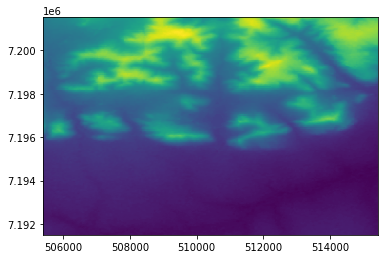

In [11]:
plt.pcolormesh(
    grid.origin["x"] + grid.cell_center_u,
    grid.origin["y"] + grid.cell_center_v,
    dem.values.reshape(grid.shape),
)

## Creating objects

The `geoh5` format supports a wide range of object types as [documented here](https://geoh5py.readthedocs.io/en/stable/content/geoh5_format/analyst/objects.html#analyst-objects). For this training, we will create a simple `Points` object using the `.create()` method.


For the `Points` to be fully defined, we need to at least assign vertices as an array of 3D coordinates `shape(*, 3)`.
Let's add one point at the Sun City resort.

In [12]:
point = Points.create(workspace, vertices=np.c_[510000, 7196500, 1150])
workspace.close()

Since we have closed workspace, you can now safely open the `suncity.geoh5` with ANALYST to see the result.

![grid2d](./images/grid2d.png)

## Generating Data

Now that we have an object created, we can add data to it. We will borrow
some functions from the `numpy` package to compute values on the cells of our 2D grid.

### Example 1: Magnetic dipole field

Let's start with a simple problem of computing the magnetic field due to a
dipole. This can later become a useful tool to interpret magnetic maps.

From first year physics, the magnetic field of a single dipole is:

$$\mathbf{B} = \frac{\mu_0}{4 \pi}  \frac{3 (\mathbf{m} \cdot \mathbf{r})  \mathbf{\hat r} - \mathbf{m}}{r^3}$$

where $\mu_0$ is a constant ($4 \pi 1e-9$), $\mathbf{m}$ is the magnetic dipole and $\mathbf{r}$ is the
vector separating the dipole and the observations (our grid cells).

We can first create a small function that computes the magnetic field for a single dipole.

In [13]:
def b_field(locations, moment, azimuth, dip, grid):
    """
    Compute the magnetic field components of a dipole on a Grid2D cells.
    """
    theta = np.deg2rad((450 - azimuth) % 360)
    phi = np.deg2rad(90 - dip)

    m = (
        moment
        * np.c_[np.sin(phi) * np.cos(theta), np.sin(phi) * np.sin(theta), np.cos(phi)]
    )

    delta = locations - grid.centroids
    radius = np.sum(delta**2.0, axis=1) ** 0.5
    fields = (np.dot(m, delta.T).T * delta) / radius[:, None] ** 4.0 - np.repeat(
        m, grid.n_cells
    ).reshape((-1, 3), order="F") / radius[:, None] ** 3.0

    return fields

We can now use our function to compute the fields on the existing grid.

In [14]:
moment, azimuth, dip = 1.0, 90, 0
b = b_field(point.vertices, moment, azimuth, dip, grid)

We then add the total electric field to our Grid2D.

In [15]:
with workspace.open():
    grid.add_data(
        {
            "b_x": {"values": b[:, 0]},
            "b_y": {"values": b[:, 1]},
            "b_z": {"values": b[:, 2]},
        }
    )

Similarly, we can add data to the Points to show the strength and direction of the dipole moment. We are going to group those data entities so that we can display them as arrow in ANALYST.

In [16]:
with workspace.open():
    params = point.add_data(
            {
                "moment": {"values": np.r_[moment]},
                "azimuth": {"values": np.r_[azimuth]},
                "dip": {"values": np.r_[dip]},
            }
        )
    prop_group = point.find_or_create_property_group(name="dipole", property_group_type="Dip direction & dip")
    point.add_data_to_group(params[1:], prop_group)

Et voila!

![bfield](./images/b_field.png)

For more examples on how to create other object types, visit the [geoh5py-Tutorial](https://geoh5py.readthedocs.io/en/stable/content/user_guide/core_entities.html#Entities)

 Copyright (c) 2022 Mira Geoscience Ltd.